In [11]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture as EM
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.cm as cm
import itertools
import timeit
from collections import Counter

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.mixture import GaussianMixture as EM
from sklearn.metrics import silhouette_score as sil_score, f1_score, homogeneity_score
import matplotlib.pyplot as plt

np.random.seed(0)

def cluster_predictions(Y,clusterLabels):
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
#    assert max(pred) == max(Y)
#    assert min(pred) == min(Y)    
    return pred

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

def run_EM(X,y,title):

    #kdist =  [2,3,4,5]
    #kdist = list(range(2,51))
    kdist = list(np.arange(2,100,5))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []; aic_scores = []; bic_scores = []
    
    for k in kdist:
        start_time = timeit.default_timer()
        em = EM(n_components=k,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        
        labels = em.predict(X)
        sil_scores.append(sil_score(X, labels))
        y_mode_vote = cluster_predictions(y,labels)
        f1_scores.append(f1_score(y, y_mode_vote))
        homo_scores.append(homogeneity_score(y, labels))
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))
        
    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Elbow Plot for EM: '+ title)
    plt.show()
   
    # plot homogeneity scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, homo_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Homogeneity Score')
    plt.title('Homogeneity Scores EM: '+ title)
    plt.show()

    # plot f1 scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, f1_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores EM: '+ title)
    plt.show()

    # plot model AIC and BIC
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, aic_scores, label='AIC')
    ax.plot(kdist, bic_scores,label='BIC')
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Model Complexity Score')
    plt.title('EM Model Complexity: '+ title)
    plt.legend(loc="best")
    plt.show()
    
def evaluate_EM(em, X, y):
    start_time = timeit.default_timer()
    em.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    labels = em.predict(X)
    y_mode_vote = cluster_predictions(y,labels)
    auc = roc_auc_score(y, y_mode_vote)
    f1 = f1_score(y, y_mode_vote)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote)
    recall = recall_score(y, y_mode_vote)
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(em.n_iter_))
    print("Log-likelihood Lower Bound: {:.2f}".format(em.lower_bound_))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()

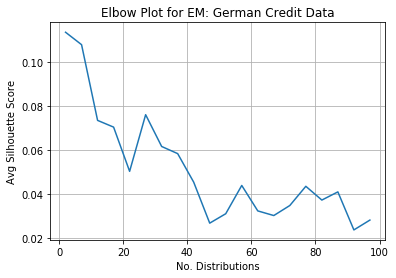

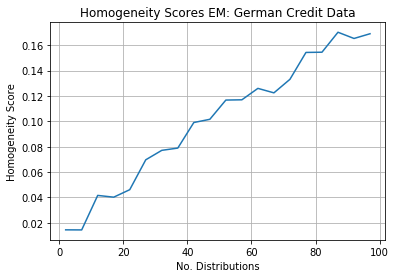

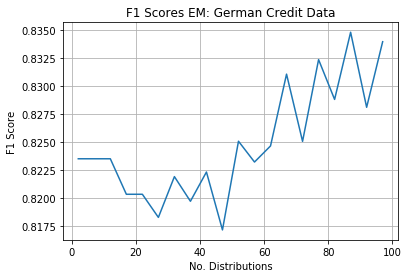

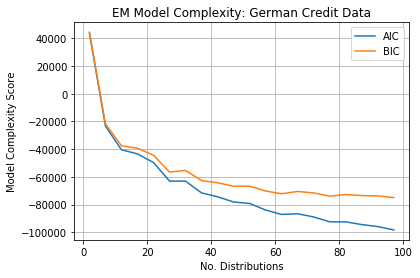

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.03
No. Iterations to Converge: 14
Log-likelihood Lower Bound: 29.86
F1 Score:  0.82
Accuracy:  0.70     AUC:       0.54
Precision: 0.72     Recall:    0.96
*****************************************************


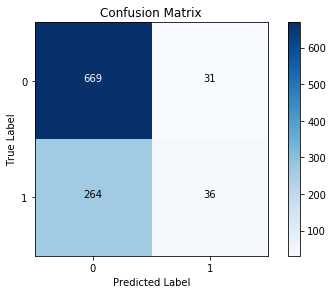

In [12]:
np.random.seed(5)

credit=np.genfromtxt('../dataset/german.data-numeric.txt') 
X,y = credit[:,:-1], credit[:,-1:].squeeze() 
X = scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111, stratify=y)


run_EM(X,y,'German Credit Data')
em = EM(n_components=24,covariance_type='diag',n_init=1,warm_start=True,random_state=100)
evaluate_EM(em,X,y)
# df = pd.DataFrame(em.means_)
# df.to_csv("Phishing EM Component Means.csv")

